<a href="https://colab.research.google.com/github/Ikeda33/codespaces-railstutorial/blob/main/vit2_50epoch_flower_D_v_G_sa_FID_KID_devide_1_color_relativistic1_hinge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#パッケージのダウンロード


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import argparse

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
import torchvision.transforms as transforms

In [ ]:
import torchvision.datasets as dset

In [ ]:
import torchvision.utils as vutils

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tqdm

In [ ]:
import glob

In [ ]:
from torch.utils.data import Dataset
from PIL import Image

In [ ]:
from torch.utils.data import DataLoader
import torchvision

In [ ]:
!pip install torchmetrics
!pip install torchmetrics[image]

!pip install torch-fidelity

from torchmetrics.image.inception import InceptionScore


import torchmetrics
import torch_fidelity

import torch
_ = torch.manual_seed(123)
from torchmetrics.image.fid import FrechetInceptionDistance
fid = FrechetInceptionDistance(feature=2048)

from torchmetrics.image.kid import KernelInceptionDistance


In [ ]:
kid = KernelInceptionDistance(subset_size=15)

In [ ]:
#ハイパーパラメータの設定

In [ ]:
parser = argparse.ArgumentParser()
parser.add_argument("--n_epoch", type = int, default=50)
parser.add_argument("--batch_size", type = int, default=32)
parser.add_argument("--lr_g", type = float, default=2e-4)
parser.add_argument("--lr_d", type = float, default=3e-4)
parser.add_argument("--nch_g", type = int, default=64)
parser.add_argument("--nch_d", type = int, default=64)
parser.add_argument("--z_dim", type = int, default=100)
parser.add_argument("--beta1", type = float, default=0.5)

opt = parser.parse_args(args=[])
print(opt)

Namespace(n_epoch=50, batch_size=32, lr_g=0.0002, lr_d=0.0003, nch_g=64, nch_d=64, z_dim=100, beta1=0.5)


In [ ]:
class ImageDataset(Dataset):
    def __init__(self,  transform = None):
        super().__init__()
        self.file_list = glob.glob("/content/drive/MyDrive/102flowers (2)/jpg/*.jpg")#/content/drive/MyDrive/img_align_celeba.zip
        #self.file_list = glob.glob("/content/drive/MyDrive/cityscapes/cityscapes_data/train/*.jpg" )#/content/drive/MyDrive/cityscapes/cityscapes_data/train
        #self.file_list = glob.glob("/content/drive/MyDrive/Test/**/*.jpg" )#fruits
       # self.file_list = glob.glob("/content/drive/MyDrive/img_align_celeba.zip/jpg/*.jpg")#C:\Users\ikeda\Downloads\img_align_celeba\img_align_celeba
        #self.file_list = glob.glob("/content/drive/MyDrive/–¢Šm”F 758452(1).crdownload/*.jpg")
        self.transform = transform


    def __getitem__(self, index):
        if self.transform is not None:
            img = self.transform(Image.open(self.file_list[index]))
        else:
            img = Image.open(self.file_list[index])
        return img

    def __len__(self):
        return len(self.file_list)

In [ ]:
from torchvision.transforms.transforms import CenterCrop

transform = transforms.Compose([

    transforms.Resize(80),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
                               transforms.Normalize((0.5,),(0.5,))])

In [ ]:
#dataset = dset.MNIST("./", train = True, download = True,transform = transform)
dataset = ImageDataset(transform = transform)
#dataset = torchvision.datasets.CelebA("./", split = "test", download = True,transform = transform) #Cityscapes
#dataset = torchvision.datasets.Cityscapes("C:\Users\ikeda\Downloads\cityscapes\cityscapes_data\cityscapes_data", split='train', mode='fine', target_type='color')


In [ ]:
dataloader = DataLoader(dataset = dataset, batch_size = opt.batch_size,num_workers = 2,  shuffle = True)

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


In [ ]:
#モデルの設定

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        out_channels = in_channels
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.se_block_0 = SE(out_channels)
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x

    def forward(self, x):
        identity = x#入力
        x = self.conv1(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = x + self.shortcut(identity)
        return x

In [ ]:
class ResidualBlock_G(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        out_channels = in_channels
        self.conv1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv2 = nn.utils.spectral_norm(nn.ConvTranspose2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.se_block_0 = SE_G(out_channels)
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x

    def forward(self, x):
        identity = x#入力
        x = self.conv1(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = x + self.shortcut(identity)
        return x

In [ ]:
class ResidualBlock_1(nn.Module):#実質パディングとスペクトラム正規化とインスタンス正規化
  def __init__(self, in_channels):
    super().__init__()
    self.conv_layers = nn.Sequential(
        nn.ReflectionPad2d(1),
        nn.utils.spectral_norm(nn.Conv2d(in_channels, in_channels, 3)),
        nn.InstanceNorm2d(in_channels),
        nn.ReLU(inplace = True),

        nn.ReflectionPad2d(1),
        nn.utils.spectral_norm(nn.Conv2d(in_channels, in_channels, 3)),
        nn.InstanceNorm2d(in_channels),

    )
  def forward(self, x):
    out = self.conv_layers(x)
    out = out + x
    return out

In [ ]:
class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        n_divide = in_channels
        #out_channels = in_channels // n_divide
        out_channels = 1

        self.fx_1x1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        self.gx_1x1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        self.hx_1x1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2


    def forward(self, x):
        B, C, H, W = x.size()
        #x = nn.LayerNorm([C,H,W])#input.size()[1:]
        fx = self.fx_1x1(x).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(x).view(B, -1, H*W)
        hx = self.hx_1x1(x).view(B, -1, H*W)

        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)

        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o
        return out

In [ ]:
#import torch
#from layers.transformer.ScaledDotProductAttention import ScaledDotProductAttention
#from torch import nn


class MultiHeadAttention(nn.Module):
    def __init__(self, in_channels, h = 8):
        super().__init__()
        d_model = in_channels
        self.d_model = in_channels
        self.h = in_channels
        self.d_k = d_model // h
        self.d_v = d_model // h
        self.fx_1x1 = (nn.Conv2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.gx_1x1 = (nn.Conv2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.hx_1x1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, in_channels, kernel_size = 1))
        self.qkv = nn.utils.spectral_norm(nn.Conv2d(in_channels, 3 * in_channels, kernel_size = 1))

#        self.scaled_dot_product_attention = SelfAttention(self.d_model)

        self.linear = nn.Linear(self.h * self.d_v, d_model)
       # self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        #self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        #self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2

        self.se_block_0 = SE(in_channels)
        self.relu = nn.ReLU()

    def forward(self, x ) -> torch.Tensor:
        B, C, H, W = x.size()
        qkv = self.qkv(x)
        self.q, self.k, self.v = qkv.chunk(3, dim = 1)

        #self.q = self.se_block_0(self.q)
        #self.k = self.se_block_0(self.k)
        #self.v = self.se_block_0(self.v)

        """Scaled dot product attention"""
       # attention_output = self.scaled_dot_product_attention(self.q, self.k, self.v)  # (head*batch_size, seq_len, d_model)
        B, C, H, W = self.q.size()
        #x = nn.LayerNorm([C,H,W])#input.size()[1:]
        fx = self.fx_1x1(self.q).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(self.k).view(B, -1, H*W)
        hx = self.hx_1x1(self.v).view(B, -1, H*W)
       # fx = self.q.view(B, -1, H*W).permute(0,2,1)
       # gx = self.k.view(B, -1, H*W)
       # hx = self.v.view(B, -1, H*W)

        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)

        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o

        #out = out.repeat(1,self.h*1,1,1)

        #out = torch.chunk(out, self.h, dim=1)
       # out = torch.cat(out, dim=1)

        """Linear after scaled dot product attention"""
        #output = self.linear(out)
        return out


In [ ]:

class MultiHeadAttention_G(nn.Module):
    def __init__(self, in_channels, h = 8):
        super().__init__()
        d_model = in_channels
        self.d_model = in_channels
        self.h = in_channels
        self.d_k = d_model // h
        self.d_v = d_model // h
        self.fx_1x1 = (nn.ConvTranspose2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.gx_1x1 = (nn.ConvTranspose2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.hx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, in_channels, kernel_size = 1))
        self.qkv = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, 3 * in_channels, kernel_size = 1))

#        self.scaled_dot_product_attention = SelfAttention(self.d_model)

        self.linear = nn.Linear(self.h * self.d_v, d_model)
       # self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        #self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        #self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2

        self.se_block_0 = SE_G(in_channels)
        self.relu = nn.ReLU()

    def forward(self, x ) -> torch.Tensor:
        B, C, H, W = x.size()
        qkv = self.qkv(x)
        qkv = self.relu(qkv)
        self.q, self.k, self.v = qkv.chunk(3, dim = 1)

        #self.q = self.se_block_0(self.q)
        #self.k = self.se_block_0(self.k)
        #self.v = self.se_block_0(self.v)
        """Scaled dot product attention"""
       # attention_output = self.scaled_dot_product_attention(self.q, self.k, self.v)  # (head*batch_size, seq_len, d_model)
        B, C, H, W = self.q.size()
        #x = nn.LayerNorm([C,H,W])#input.size()[1:]
        fx = self.fx_1x1(self.q).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(self.k).view(B, -1, H*W)
        hx = self.hx_1x1(self.v).view(B, -1, H*W)
       # fx = self.q.view(B, -1, H*W).permute(0,2,1)
       # gx = self.k.view(B, -1, H*W)
       # hx = self.v.view(B, -1, H*W)

        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)

        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o

        #out = out.repeat(1,self.h*1,1,1)

        #out = torch.chunk(out, self.h, dim=1)
       # out = torch.cat(out, dim=1)

        """Linear after scaled dot product attention"""
        #output = self.linear(out)
        return out

In [ ]:
class SelfAttention_G(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        n_divide = in_channels
        out_channels = in_channels // n_divide
      #  out_channels = 1

        self.fx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels, kernel_size = 1))
        self.gx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels, kernel_size = 1))
        self.hx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, in_channels, kernel_size = 1))
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2


    def forward(self, x):
        B, C, H, W = x.size()
        fx = self.fx_1x1(x).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(x).view(B, -1, H*W)
        hx = self.hx_1x1(x).view(B, -1, H*W)

        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)

        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o
        return out

In [ ]:
class PF(nn.Module):#poolformer
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))#kernel_size=4, stride=2, padding=1
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.pre_bn = nn.BatchNorm2d(in_channels)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size = 3, stride = 1, padding = 3//2, count_include_pad=False)
        self.flat = nn.Flatten()
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x

    def forward(self, x):
        identity = x#入力
        x = self.pre_bn(x)
        x = self.pool(x) -x
        x = x + identity

        identity = x#入力
        x = self.pre_bn(x)
        x= self.flat(x)
        x = self.conv1(x)
        x = self.relu(x)
        x = x + self.shortcut(identity)
        return x

In [ ]:
"""    def __init__(self, in_channels):
        super().__init__()
        n_divide = 8
        out_channels = in_channels // n_divide
        self.dim = 3

        self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))#kernel_size=4, stride=2, padding=1
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size==1 -> チャネル数だけ変化させること
        self.pre_bn = nn.BatchNorm2d(in_channels)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool= nn.AvgPool2d(kernel_size =self.dim , stride = 1, padding = 0, count_include_pad=False)
        self.sigmoid = nn.Sigmoid()


    def forward(self, x):
        B, C, H, W = x.size()
        z = self.pre_bn(x)
        z = self.pool(z, self.dim = H)

        z = self.conv1(z)
        z = self.relu(z)

        z = self.conv2(z)
        z = self.sigmoid(z)

        z = torch.einsum("bchw,bchw->bchw",(x, z))
        out = x + self.gamma * z
        return out
"""

'    def __init__(self, in_channels):\n        super().__init__()\n        n_divide = 8\n        out_channels = in_channels // n_divide\n        self.dim = 3\n\n        self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm\n        self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#\n        self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#\n        self.gamma = nn.Parameter(torch.zeros(1))\n        self.softmax = nn.Softmax(dim = -2)#規格化するため -2\n        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))#kernel_size=4, stride=2, padding=1\n        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))\n        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size==1 -> チャネル数だけ変化させること\n        self.pre_bn = nn.BatchNorm2d(in_channels)\n        self.bn = n

In [ ]:
class SE(nn.Module):#SE_Block layerに対して作用するattentionのようなモデル
    def __init__(self, in_channels, reduction=24):
        super().__init__()
        channel = in_channels
        reduction = in_channels
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
           # nn.Linear(channel, channel// reduction , bias=False),
            (nn.Conv2d(in_channels, in_channels// reduction,kernel_size = 1, padding = 0)),
            nn.ReLU(inplace=True),
            #nn.Linear(channel // reduction, channel, bias=False),
            (nn.Conv2d(in_channels// reduction,in_channels,kernel_size = 1, padding = 0)),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        #y = self.avg_pool(x).view(b, c)
        y = self.avg_pool(x)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)




In [ ]:
class SE_G(nn.Module):#SE_Block layerに対して作用するattentionのようなモデル
    def __init__(self, in_channels, reduction=24):
        super().__init__()
        channel = in_channels
        reduction = in_channels
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            #nn.Linear(channel, channel// reduction , bias=False),
            nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, in_channels// reduction,kernel_size = 1, padding = 0)),
            nn.ReLU(inplace=True),
            #nn.Linear(channel // reduction, channel, bias=False),
            nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels// reduction,in_channels,kernel_size = 1, padding = 0)),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

In [ ]:
#nn.ConvTranspose2d
class PF_G(nn.Module):#poolformer
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size=3, padding=1))
        self.conv2 = nn.utils.spectral_norm(nn.ConvTranspose2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.pre_bn = nn.BatchNorm2d(in_channels)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size = 3, stride = 1, padding = 3//2, count_include_pad=False)
        self.flat = nn.Flatten()
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x

    def forward(self, x):
        identity = x#入力
        x = self.pre_bn(x)
        x = self.pool(x) - x
        x = x + identity

        identity = x#入力
        x = self.pre_bn(x)
        x = self.flat(x)
        x = self.conv1(x)
        x = self.relu(x)
        x = x + self.shortcut(identity)
        return x

In [ ]:
"""(((W - K + 2P)/S) + 1)
    Here W = Input size
    K = Filter size
    S = Stride
    P = Padding
    ((Input_size-kernel_size + 2*Padding)/stride)+ 1
    この式を使用できます[(W−K+2P)/S]+1。

W は入力ボリュームです - あなたの場合は 128
Kはカーネルサイズです - あなたの場合は5です
P はパディングです - あなたの場合は 0 だと思います
S はストライドです - あなたが提供していません。
したがって、次の式に入力します。
for example
Output_Shape = (128-5+0)/1+1

Output_Shape = (124,124,40)
output==1 ,1  = (W - k + 2p)/s = 0   s = 1, p = 0 ,k = W
    """



'(((W - K + 2P)/S) + 1)\n    Here W = Input size\n    K = Filter size\n    S = Stride\n    P = Padding\n    ((Input_size-kernel_size + 2*Padding)/stride)+ 1\n    この式を使用できます[(W−K+2P)/S]+1。\n\nW は入力ボリュームです - あなたの場合は 128\nKはカーネルサイズです - あなたの場合は5です\nP はパディングです - あなたの場合は 0 だと思います\nS はストライドです - あなたが提供していません。\nしたがって、次の式に入力します。\nfor example\nOutput_Shape = (128-5+0)/1+1\n\nOutput_Shape = (124,124,40)\noutput==1 ,1  = (W - k + 2p)/s = 0   s = 1, p = 0 ,k = W\n    '

In [ ]:
class VIT(nn.Module):
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.pre_bn = nn.BatchNorm2d(in_channels)

        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size = 3, stride = 1, padding = 3//2)
        self.attention = SelfAttention(in_channels)
        self.se_block_0 = SE(in_channels)
        self.se_block_1 = SE(out_channels)

        self.flat = nn.Flatten()

        self.linear_1 = nn.Linear(32,64, bias=False)
        self.linear_2 = nn.Linear( 32,32, bias=False)#if ( 64,32, bias=False)  -> mat1 and mat2 shapes cannot be multiplied (131072x32 and 64x32)


    def shortcut(self, x):
        x = self.conv3(x)
        #x = self.se_block_1(x)
        x = self.bn(x)
        return x

    def forward(self, x):

        identity = x#入力
        x = self.pre_bn(x)
       # x = self.se_block_0(x)
        x = self.attention(x) - x
        x = x + identity


        identity = x#入力
        x = self.pre_bn(x)
       # b, c, h, w = x.size()
        x = self.conv1(x)


      #  x = self.linear_1(x).view(b, -1, h, w)
        x = self.relu(x)
       # x = self.linear_2(x).view(b, -1, h, w)


        x =  self.shortcut(identity) + x
        #x = x + self.shortcut(identity)
        x = self.bn(x)

        return x

In [ ]:
#nn.ConvTranspose2d
class VIT_G(nn.Module):
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size=3, padding=1))
        self.conv2 = nn.utils.spectral_norm(nn.ConvTranspose2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size=1 -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.pre_bn = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size = 3, stride = 1, padding = 3//2, count_include_pad=False)
        self.attention = MultiHeadAttention_G(in_channels)

    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x

    def forward(self, x):
        identity = x#入力
        x = self.pre_bn(x)
        x = self.attention(x) - x
        x = x + identity

        #identity = x#入力
        x = self.pre_bn(x)
        x = self.conv1(x)
        x = self.relu(x)
        x = x + self.shortcut(identity)
        return x

In [ ]:
class Generator(nn.Module):
    def __init__(self,pf, vit, resnet,res_net,sa,z_dim = opt.z_dim, ngf = opt.nch_g, nc = 3):# ものくろだからnc=1 カラーならnc=3
        super().__init__()

        self.convt1 = self.conv_trans_layers(z_dim, 8*ngf, 4,1,0 )# ngf = the number of channels

        self.convt2 = self.conv_trans_layers(8*ngf, 4*ngf, 4, 2, 1 )
        self.convt3 = self.conv_trans_layers(4*ngf,  2*ngf, 4,2,1)
        self.convt4 = self.conv_trans_layers(2*ngf,  ngf, 4,2,1 )

        self.pf1 = pf(z_dim, 8*ngf)
        self.vit1 = vit(z_dim, 8*ngf)

        self.pf2 = pf(8*ngf, 4*ngf)
        self.vit2 = vit(8*ngf, 4*ngf)

        self.pf3 = pf(4*ngf,  2*ngf)
        self.vit3 = vit(4*ngf,  2*ngf)

        self.pf4 = pf(2*ngf,  ngf)
        self.vit4 = vit(2*ngf,  ngf)

        self.convt5 = nn.Sequential(
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1),
            #self.conv_trans_layers(ngf, nc, 4,2,1  )
            nn.Tanh()
        )


    @staticmethod
    def conv_trans_layers(in_channels, out_channels, kernel_size, stride, padding, has_norm=True,attention=True, res_net= False, se = False):
        layers = [nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding))]#spectralnorm
        if has_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        #layers.append(nn.ReLU(inplace = True))
        layers.append(nn.LeakyReLU(0.2, inplace = True))
        if se:
            layers.append(SE_G(out_channels))
        if attention:
            layers.append(SelfAttention_G(out_channels))
        if res_net:
            layers.append(ResidualBlock_G(out_channels))



        net = nn.Sequential(*layers)#listのアンパック

        return net

    def forward(self, x):
        out = self.convt1(x)

        out = self.convt2(out)

        out = self.convt3(out)

        out = self.convt4(out)

        out = self.convt5(out)


        return out

In [ ]:
from pickle import FALSE
class Discriminator(nn.Module):
    def __init__(self,pf,vit ,resnet,res_net,sa,nc = 3, ndf = opt.nch_d):# ものくろだからnc=1 カラーならnc=3
        super().__init__()
        self.conv1 = self.conv_layers(nc, ndf)
        self.pf1 = pf(nc,ndf)
        self.vit1 = vit(nc,ndf)

        self.conv2 = self.conv_layers(ndf, 2*ndf )
        self.pf2 = pf(ndf, 2*ndf)
        self.vit2 = vit(ndf, 2*ndf)

        self.conv3 = self.conv_layers(2*ndf, 4*ndf )
        self.pf3 = pf(2*ndf, 4*ndf )
        self.vit3 = vit(2*ndf, 4*ndf )

        self.conv4 = self.conv_layers(4*ndf, 8*ndf)
        self.pf4 = pf(4*ndf, 8*ndf)
        self.vit4 = vit(4*ndf, 8*ndf)

        self.vit5 = vit(8*ndf, 16*ndf)

        self.conv5 =  nn.Conv2d(8*ndf, 1,  4)
        #self.conv6 =  nn.Conv2d(16*ndf, 1,  4)


    @staticmethod
    def conv_layers(in_channels, out_channels, kernel_size=4, stride=2, padding=1, has_batch_norm = True, attention = False, res_net = False, se = False):
        layers = [nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding))]
        if has_batch_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2, inplace = True))
        if se:
            layers.append(SE(out_channels))
        if attention:
            layers.append(SelfAttention(out_channels))

        if res_net:
            layers.append(ResidualBlock(out_channels))


        net = nn.Sequential(*layers)#listのアンパック

        return net

    def forward(self, x):
        out = self.conv1(x)

        out = self.vit2(out)

        out = self.vit3(out)

        out = self.vit4(out)

        out = self.conv5(out)

        return out

In [ ]:
#モデルのトレーニング

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
device

device(type='cuda')

In [ ]:
netG = Generator(PF_G,VIT_G,ResidualBlock,ResidualBlock_1,SelfAttention, z_dim=opt.z_dim , ngf=opt.nch_g ).to(device)
netG.apply(weights_init)
print(netG)

netD = Discriminator(PF,VIT,ResidualBlock,ResidualBlock_1,SelfAttention, nc = 3 , ndf=opt.nch_d ).to(device)# ものくろだからnc=1 カラーならnc=3
netD.apply(weights_init)
print(netD)

Generator(
  (convt1): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): SelfAttention_G(
      (fx_1x1): ConvTranspose2d(512, 1, kernel_size=(1, 1), stride=(1, 1))
      (gx_1x1): ConvTranspose2d(512, 1, kernel_size=(1, 1), stride=(1, 1))
      (hx_1x1): ConvTranspose2d(512, 512, kernel_size=(1, 1), stride=(1, 1))
      (softmax): Softmax(dim=-2)
    )
  )
  (convt2): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): SelfAttention_G(
      (fx_1x1): ConvTranspose2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
      (gx_1x1): ConvTranspose2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
      (hx_1x1): ConvTranspo

In [ ]:
#criterion = nn.BCELoss()
#criterion = torch.nn.HingeEmbeddingLoss()
optimizerG = optim.Adam(netG.parameters(), lr = opt.lr_g, betas= (opt.beta1, 0.999), weight_decay = 1e-5)
optimizerD = optim.Adam(netD.parameters(), lr = opt.lr_d, betas= (opt.beta1, 0.999), weight_decay = 1e-5)

100%|██████████| 103/103 [01:00<00:00,  1.70it/s]


epoch: 0, lossD:1.3422425221470953, lossG:4.725767760600858,lossG_fake:2.2513123843276386, lossG_real:2.4744553612273874 ,equality:-0.22314297689974882


evaluate:156.67587280273438,kid_mean:0.12919646501541138, kid_std:0.020607255399227142,kid_:(tensor(0.1292), tensor(0.0206))


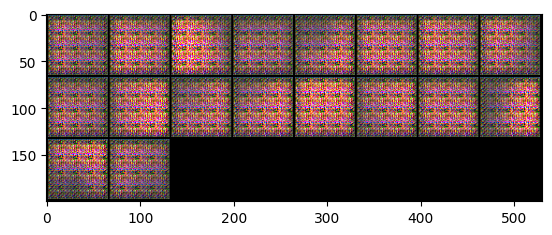

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 1, lossD:1.2255355223868658, lossG:3.9227408344305834,lossG_fake:2.1278072040057876, lossG_real:1.7949336304247958 ,equality:0.3328735735809918


evaluate:125.95032501220703,kid_mean:0.06942262500524521, kid_std:0.028043728321790695,kid_:(tensor(0.0694), tensor(0.0280))


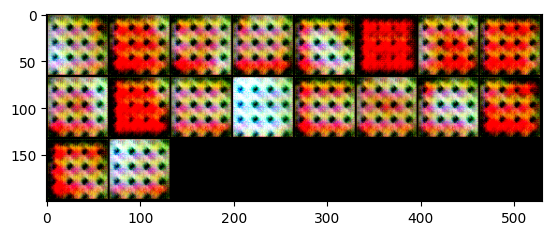

100%|██████████| 103/103 [00:58<00:00,  1.76it/s]


epoch: 2, lossD:1.5532888006238104, lossG:2.9364535345614535,lossG_fake:1.585848633525441, lossG_real:1.3506049091376147 ,equality:0.23524372438782626


evaluate:116.25694274902344,kid_mean:0.06966418772935867, kid_std:0.030678031966090202,kid_:(tensor(0.0697), tensor(0.0307))


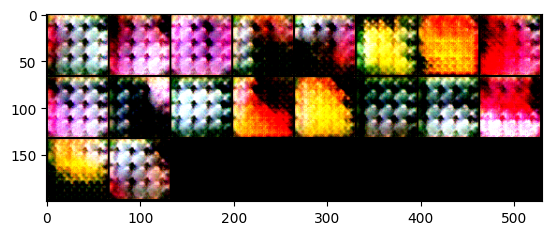

100%|██████████| 103/103 [00:58<00:00,  1.76it/s]


epoch: 3, lossD:1.7059511756434025, lossG:2.639429275271962,lossG_fake:1.4360331215904754, lossG_real:1.203396151366743 ,equality:0.2326369702237323


evaluate:108.8340072631836,kid_mean:0.06170789897441864, kid_std:0.033272020518779755,kid_:(tensor(0.0617), tensor(0.0333))


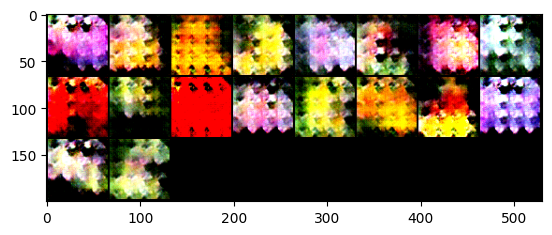

100%|██████████| 103/103 [00:58<00:00,  1.76it/s]


epoch: 4, lossD:1.7554118355501045, lossG:2.572209534135837,lossG_fake:1.3988676140609297, lossG_real:1.1733419194962214 ,equality:0.2255256945647084


evaluate:115.01510620117188,kid_mean:0.06391773372888565, kid_std:0.030884098261594772,kid_:(tensor(0.0639), tensor(0.0309))


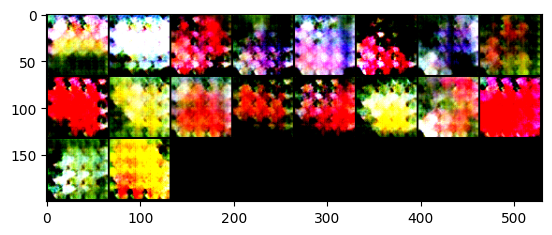

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 5, lossD:1.778507298636205, lossG:2.5909326956110093,lossG_fake:1.3899079896871327, lossG_real:1.2010247082386203 ,equality:0.1888832814485124


evaluate:110.74392700195312,kid_mean:0.06606248021125793, kid_std:0.031093595549464226,kid_:(tensor(0.0661), tensor(0.0311))


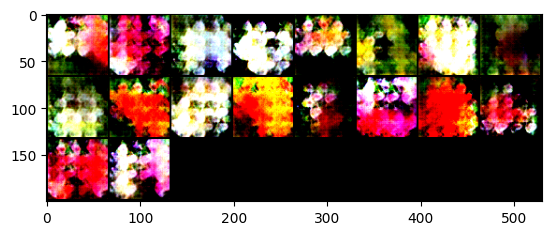

100%|██████████| 103/103 [00:58<00:00,  1.76it/s]


epoch: 6, lossD:1.758869406089042, lossG:2.6159468368419168,lossG_fake:1.3950853486662929, lossG_real:1.2208614852821942 ,equality:0.17422386338409868


evaluate:116.08815002441406,kid_mean:0.07371734082698822, kid_std:0.032916855067014694,kid_:(tensor(0.0737), tensor(0.0329))


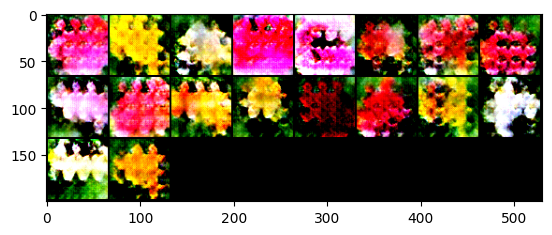

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 7, lossD:1.7343673312548296, lossG:2.6566069334456066,lossG_fake:1.4152102181055013, lossG_real:1.2413967037663876 ,equality:0.17381351433911374


evaluate:111.6297378540039,kid_mean:0.06591933965682983, kid_std:0.03527417406439781,kid_:(tensor(0.0659), tensor(0.0353))


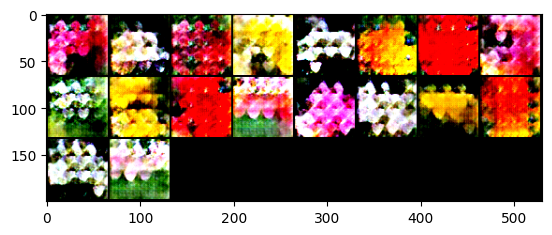

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 8, lossD:1.7554578121426037, lossG:2.668996472960537,lossG_fake:1.4145923748757074, lossG_real:1.2544040980848294 ,equality:0.160188276790878


evaluate:116.51792907714844,kid_mean:0.06882435083389282, kid_std:0.036970604211091995,kid_:(tensor(0.0688), tensor(0.0370))


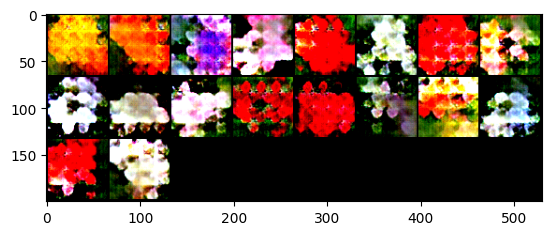

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 9, lossD:1.7293267863468058, lossG:2.678193657143602,lossG_fake:1.4326790200853812, lossG_real:1.2455146399516503 ,equality:0.18716438013373082


evaluate:118.82976531982422,kid_mean:0.0716615840792656, kid_std:0.04186428338289261,kid_:(tensor(0.0717), tensor(0.0419))


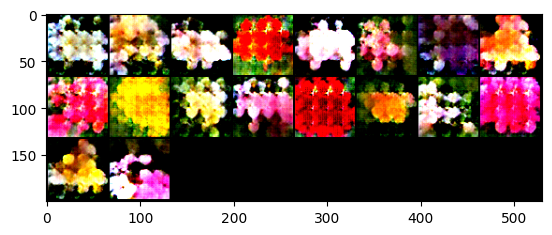

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 10, lossD:1.7392010920256087, lossG:2.6869879648523423,lossG_fake:1.4173009453467953, lossG_real:1.2696870125613167 ,equality:0.14761393278547863


evaluate:124.05475616455078,kid_mean:0.07466556131839752, kid_std:0.04028046503663063,kid_:(tensor(0.0747), tensor(0.0403))


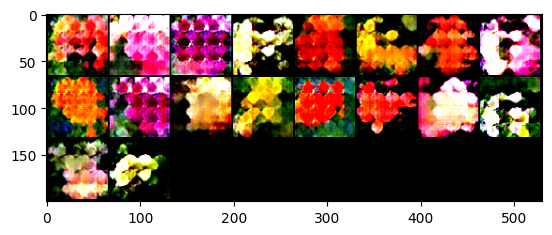

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 11, lossD:1.700950517237765, lossG:2.7344776472999053,lossG_fake:1.4566236178851821, lossG_real:1.2778540276786656 ,equality:0.1787695902065165


evaluate:122.7101821899414,kid_mean:0.08156557381153107, kid_std:0.03655639663338661,kid_:(tensor(0.0816), tensor(0.0366))


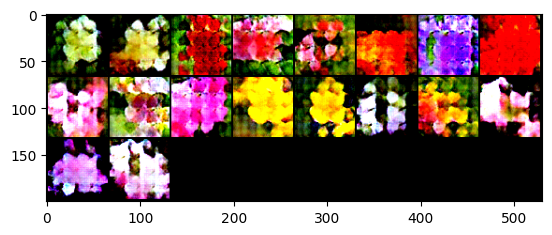

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 12, lossD:1.6761114932958363, lossG:2.822769590951864,lossG_fake:1.4991115568910989, lossG_real:1.3236580155428173 ,equality:0.17545354134828162


evaluate:123.95752716064453,kid_mean:0.07804731279611588, kid_std:0.03796019032597542,kid_:(tensor(0.0780), tensor(0.0380))


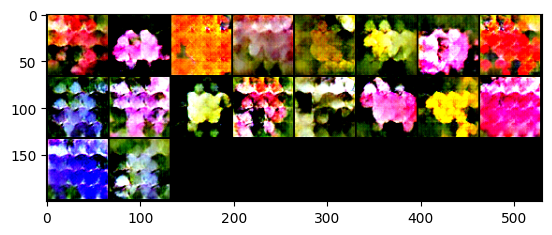

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 13, lossD:1.649734039908474, lossG:2.868772238203623,lossG_fake:1.550181756320509, lossG_real:1.3185904870912866 ,equality:0.23159126922922235


evaluate:122.3231430053711,kid_mean:0.07877643406391144, kid_std:0.03843900188803673,kid_:(tensor(0.0788), tensor(0.0384))


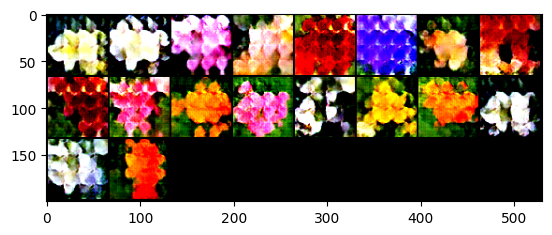

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 14, lossD:1.6176867855405344, lossG:2.93436059674013,lossG_fake:1.5620839526352372, lossG_real:1.372276642947521 ,equality:0.1898073096877162


evaluate:123.2508544921875,kid_mean:0.07264834642410278, kid_std:0.04379940405488014,kid_:(tensor(0.0726), tensor(0.0438))


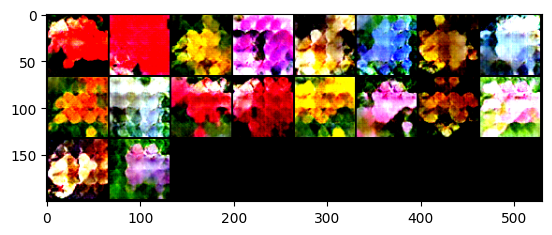

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 15, lossD:1.6280134904731824, lossG:3.0070487573308853,lossG_fake:1.6062649369818494, lossG_real:1.4007838270039235 ,equality:0.2054811099779259


evaluate:123.7924575805664,kid_mean:0.074684277176857, kid_std:0.03882647305727005,kid_:(tensor(0.0747), tensor(0.0388))


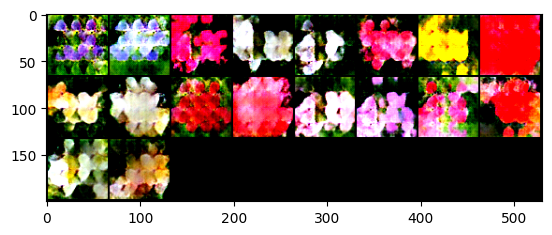

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 16, lossD:1.5520170857605424, lossG:3.0792342621145896,lossG_fake:1.6684795004650228, lossG_real:1.4107547691724833 ,equality:0.2577247312925395


evaluate:122.05979919433594,kid_mean:0.07163895666599274, kid_std:0.036208026111125946,kid_:(tensor(0.0716), tensor(0.0362))


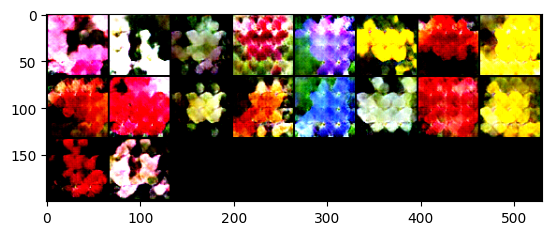

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 17, lossD:1.502898403741781, lossG:3.1673115619177956,lossG_fake:1.6759171509048314, lossG_real:1.4913944133277077 ,equality:0.18452273757712367


evaluate:123.68904876708984,kid_mean:0.07491080462932587, kid_std:0.04000783711671829,kid_:(tensor(0.0749), tensor(0.0400))


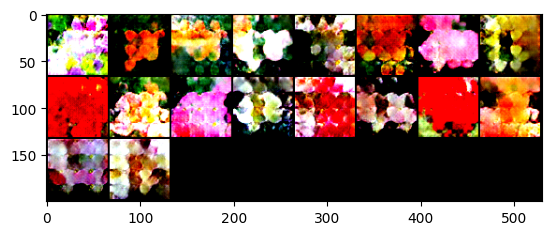

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 18, lossD:1.3758203173146664, lossG:3.3449009552742672,lossG_fake:1.7664997056849951, lossG_real:1.5784012406196408 ,equality:0.18809846506535433


evaluate:121.6099853515625,kid_mean:0.07925383746623993, kid_std:0.03871900215744972,kid_:(tensor(0.0793), tensor(0.0387))


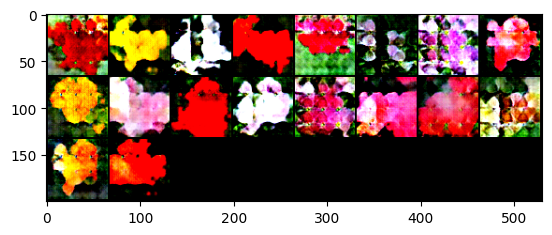

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 19, lossD:1.376844174653581, lossG:3.3859158789069905,lossG_fake:1.7934378530215291, lossG_real:1.5924780154691158 ,equality:0.2009598375524133


evaluate:121.24861145019531,kid_mean:0.07527075707912445, kid_std:0.04111533239483833,kid_:(tensor(0.0753), tensor(0.0411))


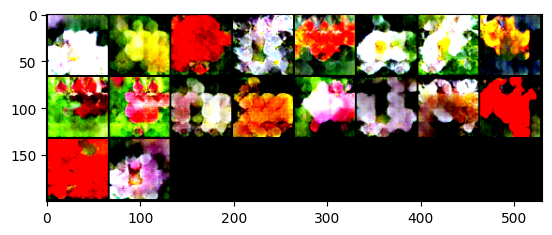

100%|██████████| 103/103 [00:58<00:00,  1.76it/s]


epoch: 20, lossD:1.3253681225684082, lossG:3.5044058966405185,lossG_fake:1.8598761008781137, lossG_real:1.6445297901202174 ,equality:0.21534631075789634


evaluate:120.36021423339844,kid_mean:0.07452133297920227, kid_std:0.038665201514959335,kid_:(tensor(0.0745), tensor(0.0387))


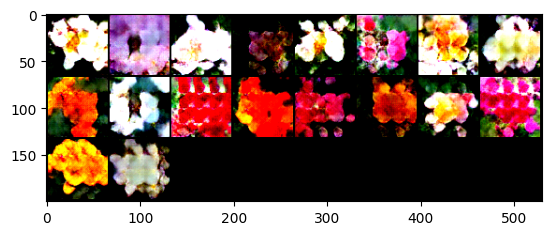

100%|██████████| 103/103 [00:58<00:00,  1.76it/s]


epoch: 21, lossD:1.269991816826237, lossG:3.6236106423498358,lossG_fake:1.8991477524192588, lossG_real:1.7244628800929171 ,equality:0.17468487232634167


evaluate:120.20267486572266,kid_mean:0.07397464662790298, kid_std:0.038676198571920395,kid_:(tensor(0.0740), tensor(0.0387))


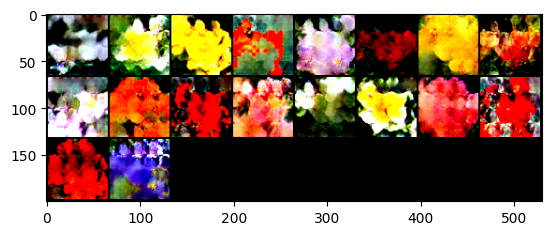

100%|██████████| 103/103 [00:58<00:00,  1.76it/s]


epoch: 22, lossD:1.2065205215250405, lossG:3.689693043532881,lossG_fake:1.944347070837484, lossG_real:1.7453459507053337 ,equality:0.1990011201321502


evaluate:118.63340759277344,kid_mean:0.07337353378534317, kid_std:0.03532090038061142,kid_:(tensor(0.0734), tensor(0.0353))


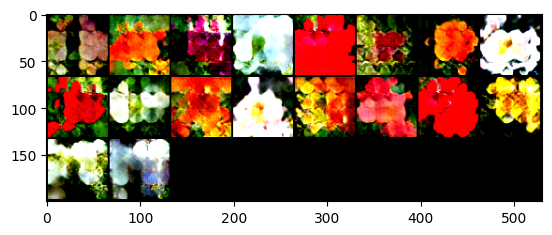

100%|██████████| 103/103 [00:58<00:00,  1.76it/s]


epoch: 23, lossD:1.1383460111988402, lossG:3.8490542555318297,lossG_fake:2.024305459365104, lossG_real:1.8247488036896418 ,equality:0.19955665567546244


evaluate:116.95281982421875,kid_mean:0.08143738657236099, kid_std:0.04047803953289986,kid_:(tensor(0.0814), tensor(0.0405))


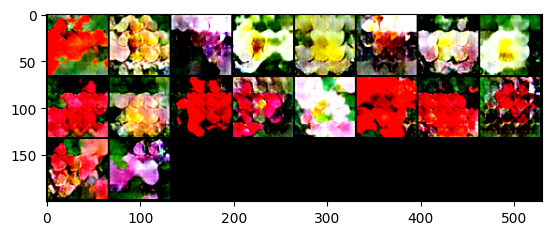

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 24, lossD:1.121779212095205, lossG:3.9462175716474217,lossG_fake:2.0839490907863505, lossG_real:1.8622684885286591 ,equality:0.22168060225769137


evaluate:118.19198608398438,kid_mean:0.07176291197538376, kid_std:0.039493344724178314,kid_:(tensor(0.0718), tensor(0.0395))


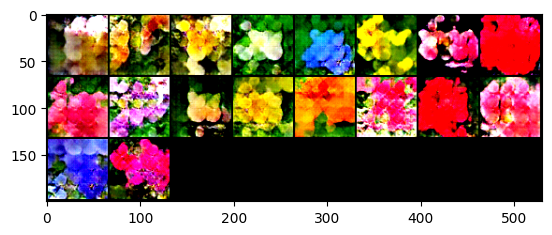

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 25, lossD:1.037637431644699, lossG:4.03528054478099,lossG_fake:2.0761341892399834, lossG_real:1.959146369429468 ,equality:0.11698781981051543


evaluate:120.37855529785156,kid_mean:0.07612930983304977, kid_std:0.03747961297631264,kid_:(tensor(0.0761), tensor(0.0375))


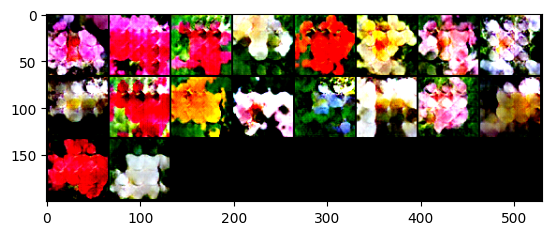

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 26, lossD:1.0210206184572386, lossG:4.042390557168757,lossG_fake:2.0892699540240094, lossG_real:1.9531206071955487 ,equality:0.1361493468284607


evaluate:120.75377655029297,kid_mean:0.07999879866838455, kid_std:0.039394304156303406,kid_:(tensor(0.0800), tensor(0.0394))


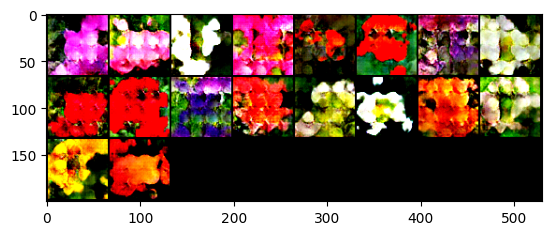

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 27, lossD:0.9655778766835778, lossG:4.241258088824819,lossG_fake:2.2239966276779914, lossG_real:2.0172614863196623 ,equality:0.20673514135832916


evaluate:120.19847869873047,kid_mean:0.07168316841125488, kid_std:0.03580857068300247,kid_:(tensor(0.0717), tensor(0.0358))


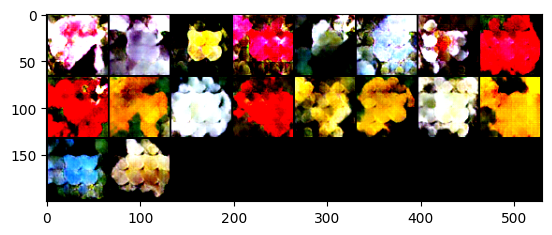

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 28, lossD:0.9480921617410716, lossG:4.26671168873611,lossG_fake:2.230284793284333, lossG_real:2.0364268763551436 ,equality:0.1938579169291894


evaluate:122.50293731689453,kid_mean:0.0745326429605484, kid_std:0.03687211871147156,kid_:(tensor(0.0745), tensor(0.0369))


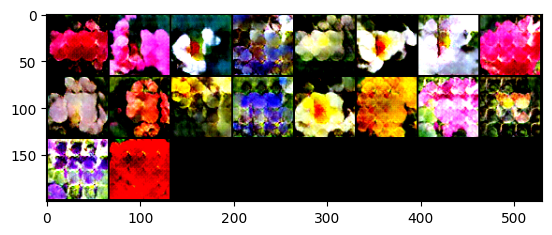

100%|██████████| 103/103 [00:58<00:00,  1.76it/s]


epoch: 29, lossD:0.8848521764417296, lossG:4.363747487947779,lossG_fake:2.2406056124029807, lossG_real:2.1231418691792534 ,equality:0.11746374322372732


evaluate:122.84664154052734,kid_mean:0.08307701349258423, kid_std:0.04382598027586937,kid_:(tensor(0.0831), tensor(0.0438))


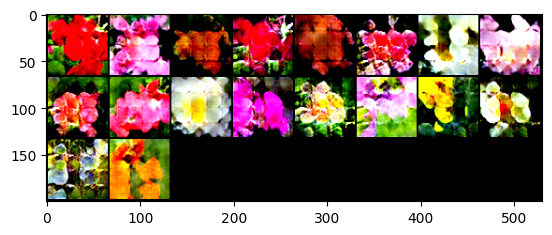

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 30, lossD:0.8162381235256936, lossG:4.514293638247888,lossG_fake:2.3244831388436475, lossG_real:2.1898104999829267 ,equality:0.1346726388607209


evaluate:123.01885223388672,kid_mean:0.07535140216350555, kid_std:0.03672776743769646,kid_:(tensor(0.0754), tensor(0.0367))


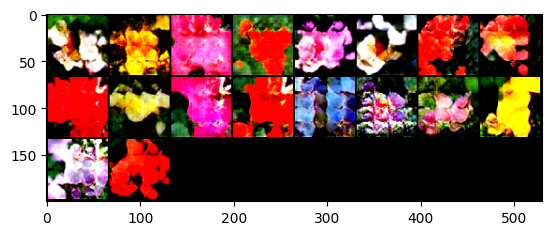

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 31, lossD:0.841530937882303, lossG:4.566855601894045,lossG_fake:2.3689057034196206, lossG_real:2.197949897317053 ,equality:0.17095580610256755


evaluate:123.1361312866211,kid_mean:0.08099552243947983, kid_std:0.03877687081694603,kid_:(tensor(0.0810), tensor(0.0388))


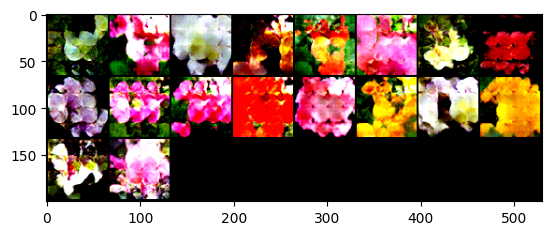

100%|██████████| 103/103 [00:58<00:00,  1.76it/s]


epoch: 32, lossD:0.7898891532016032, lossG:4.660362086249787,lossG_fake:2.471279163962429, lossG_real:2.1890829274955306 ,equality:0.2821962364668984


evaluate:122.62578582763672,kid_mean:0.07270684838294983, kid_std:0.03698866441845894,kid_:(tensor(0.0727), tensor(0.0370))


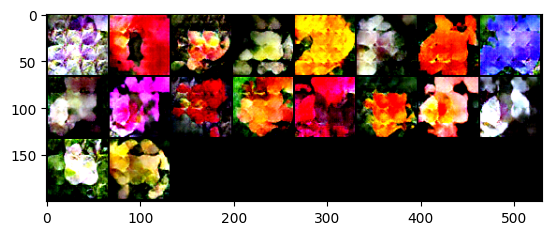

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 33, lossD:0.7513866829640657, lossG:4.747188239421659,lossG_fake:2.464669803971226, lossG_real:2.282518427927517 ,equality:0.1821513760437088


evaluate:123.31571197509766,kid_mean:0.07821264863014221, kid_std:0.04354023560881615,kid_:(tensor(0.0782), tensor(0.0435))


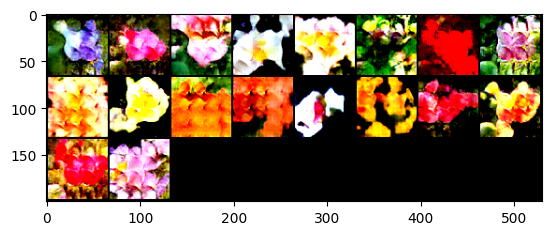

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 34, lossD:0.7724473784560139, lossG:4.7727876565988785,lossG_fake:2.44331684679661, lossG_real:2.3294708138530695 ,equality:0.11384603294354045


evaluate:123.25170135498047,kid_mean:0.08698228001594543, kid_std:0.04026917368173599,kid_:(tensor(0.0870), tensor(0.0403))


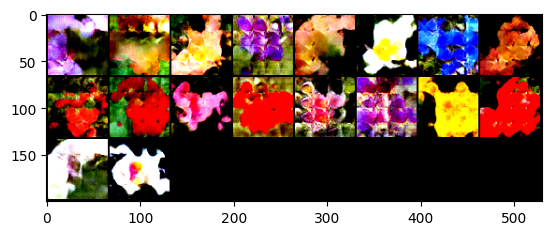

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 35, lossD:0.6315945612574086, lossG:5.088659855925921,lossG_fake:2.608575413527998, lossG_real:2.480084448763468 ,equality:0.12849096476453026


evaluate:122.16946411132812,kid_mean:0.07305271923542023, kid_std:0.04115996137261391,kid_:(tensor(0.0731), tensor(0.0412))


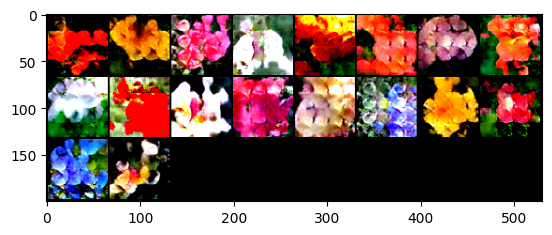

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 36, lossD:0.6171984368736304, lossG:5.07153904553756,lossG_fake:2.5805725064671154, lossG_real:2.490966549776133 ,equality:0.08960595669098259


evaluate:122.38450622558594,kid_mean:0.08079228550195694, kid_std:0.04245191439986229,kid_:(tensor(0.0808), tensor(0.0425))


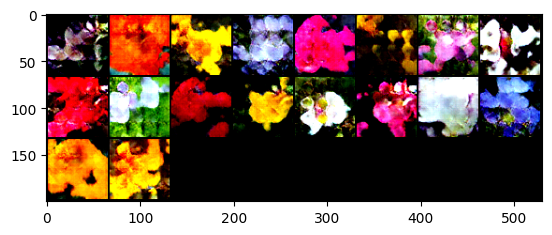

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 37, lossD:0.6314254098580879, lossG:5.177293754318385,lossG_fake:2.6611168488715458, lossG_real:2.516176893873122 ,equality:0.14493995499842383


evaluate:121.88665008544922,kid_mean:0.08134140074253082, kid_std:0.04054563120007515,kid_:(tensor(0.0813), tensor(0.0405))


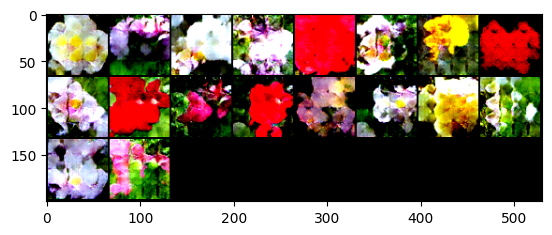

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 38, lossD:0.5509589654438704, lossG:5.31487780172848,lossG_fake:2.6837922592186234, lossG_real:2.6310855514794875 ,equality:0.05270670773913588


evaluate:123.04302978515625,kid_mean:0.07949092239141464, kid_std:0.03533565253019333,kid_:(tensor(0.0795), tensor(0.0353))


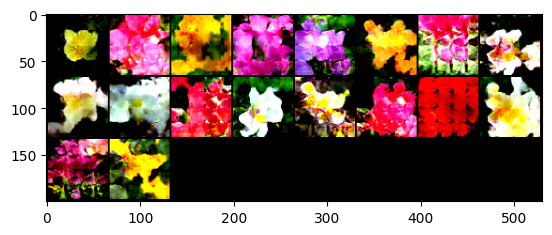

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 39, lossD:0.6595109463172052, lossG:5.369655502652659,lossG_fake:2.7536768363517465, lossG_real:2.615978669773028 ,equality:0.1376981665787187


evaluate:122.8446273803711,kid_mean:0.07840157300233841, kid_std:0.041010938584804535,kid_:(tensor(0.0784), tensor(0.0410))


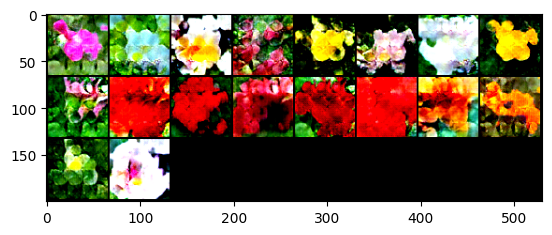

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 40, lossD:0.532232626151402, lossG:5.33017459424954,lossG_fake:2.62878576051263, lossG_real:2.7013888344602677 ,equality:-0.07260307394763776


evaluate:122.37709045410156,kid_mean:0.08045446127653122, kid_std:0.04132058098912239,kid_:(tensor(0.0805), tensor(0.0413))


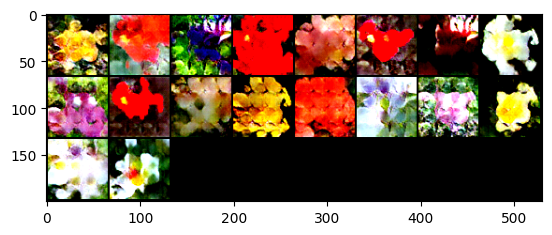

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 41, lossD:0.5289120619158143, lossG:5.463367341791542,lossG_fake:2.8031786194125425, lossG_real:2.6601887090692244 ,equality:0.1429899103433181


evaluate:122.27025604248047,kid_mean:0.08452029526233673, kid_std:0.04189431667327881,kid_:(tensor(0.0845), tensor(0.0419))


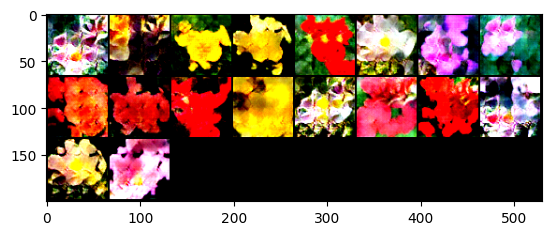

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 42, lossD:0.5052043071504936, lossG:5.498313014947095,lossG_fake:2.7779802937530778, lossG_real:2.720332709330957 ,equality:0.0576475844221207


evaluate:122.02081298828125,kid_mean:0.0746026411652565, kid_std:0.03512205928564072,kid_:(tensor(0.0746), tensor(0.0351))


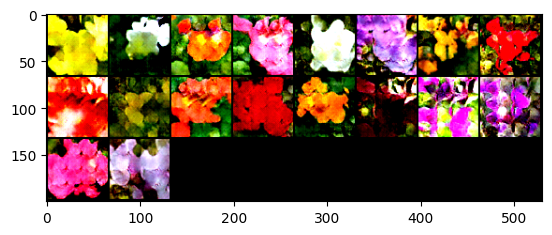

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 43, lossD:0.47936344363735717, lossG:5.6683748856331535,lossG_fake:2.934111922979355, lossG_real:2.7342629415317647 ,equality:0.1998489814475901


evaluate:122.06558990478516,kid_mean:0.08198226988315582, kid_std:0.04461406543850899,kid_:(tensor(0.0820), tensor(0.0446))


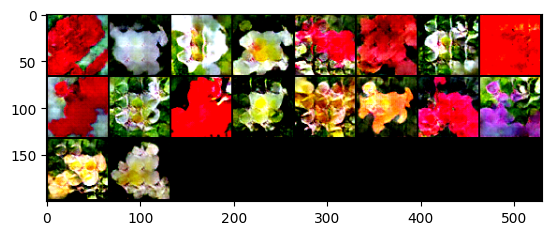

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 44, lossD:0.4914131279564598, lossG:5.688671806483593,lossG_fake:2.96713694380325, lossG_real:2.721534870781945 ,equality:0.24560207302130532


evaluate:122.41278839111328,kid_mean:0.07471909373998642, kid_std:0.04190723970532417,kid_:(tensor(0.0747), tensor(0.0419))


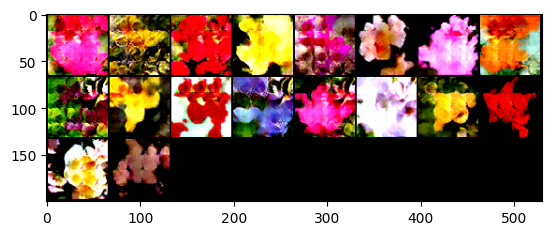

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 45, lossD:0.49314980434922917, lossG:5.619972210485958,lossG_fake:2.8026379424970127, lossG_real:2.8173342729077757 ,equality:-0.014696330410763014


evaluate:122.25430297851562,kid_mean:0.0828625038266182, kid_std:0.0469384640455246,kid_:(tensor(0.0829), tensor(0.0469))


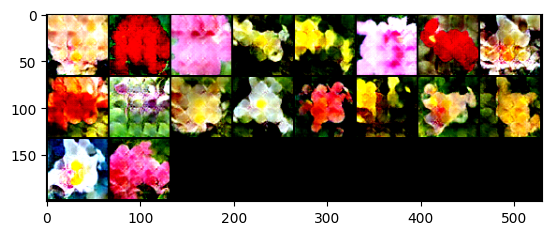

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 46, lossD:0.43465288061178425, lossG:5.746713990146674,lossG_fake:2.8900344013010413, lossG_real:2.856679573221114 ,equality:0.0333548280799274


evaluate:121.8462905883789,kid_mean:0.08164088428020477, kid_std:0.04263576865196228,kid_:(tensor(0.0816), tensor(0.0426))


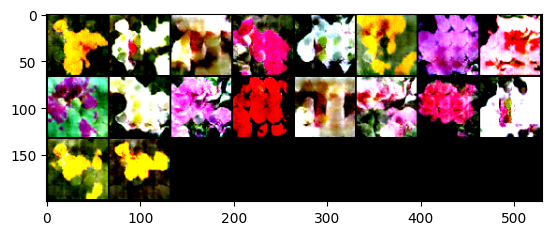

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 47, lossD:0.366712470873467, lossG:5.74435125739829,lossG_fake:2.910520450582782, lossG_real:2.8338307894549324 ,equality:0.0766896611278498


evaluate:121.3963394165039,kid_mean:0.07438974827528, kid_std:0.039043668657541275,kid_:(tensor(0.0744), tensor(0.0390))


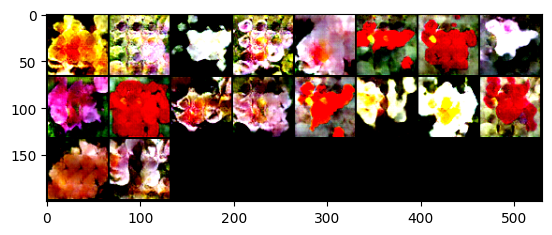

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 48, lossD:0.368730771888807, lossG:5.813961029052734,lossG_fake:2.910566836884878, lossG_real:2.903394197954715 ,equality:0.007172638930163178


evaluate:121.27127838134766,kid_mean:0.07605495303869247, kid_std:0.04104522615671158,kid_:(tensor(0.0761), tensor(0.0410))


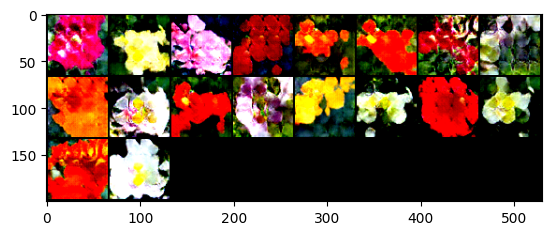

100%|██████████| 103/103 [00:58<00:00,  1.75it/s]


epoch: 49, lossD:0.42870335742939736, lossG:6.063483914125313,lossG_fake:3.150768824862045, lossG_real:2.912715083187066 ,equality:0.23805374167497906


evaluate:120.39714050292969,kid_mean:0.08141649514436722, kid_std:0.047510016709566116,kid_:(tensor(0.0814), tensor(0.0475))


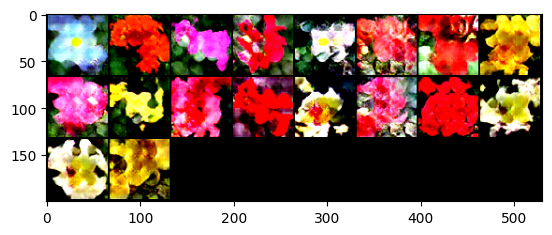

In [ ]:
lossesD = []
lossesG = []

raw_lossesD = []
raw_lossesG = []
lossesG_fake = []
lossesG_real = []

equality = 0.0
sum_equality = 0.0
d_equality = []

relu = torch.nn.ReLU()

fid_ = []
kid_mean_ = []
kid_std_ = []
kid_score = []
for epoch in range(opt.n_epoch):
    running_lossD = 0.0 #損失関数初期化
    running_lossG = 0.0
    lossG_fake_running = 0.0
    lossG_real_running = 0.0

    #sum_equality += equality
    equality = 0.0
   # for i , (real_imgs, _) in enumerate(tqdm.tqdm(dataloader, position = 0)):#celebA
    for i , real_imgs in enumerate(tqdm.tqdm(dataloader, position = 0)):#flower
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size()[0]
        noise = torch.randn(batch_size, opt.z_dim, 1, 1).to(device)

        #train discriminator

        netD.zero_grad()
        output_real = netD(real_imgs)

        #lossD_real = criterion(output, labels_real)
        lossD_real = torch.mean(relu(1.0 - output_real))


        fake_imgs = netG(noise)##not train  output_fake_d
        output_fake_d = netD(fake_imgs.detach())#not train  output_fake_d

        #lossD_fake = criterion(output, labels_fake)
        lossD_fake = torch.mean(relu(1.0 + output_fake_d))


        lossD = lossD_real + lossD_fake
        #lossD = torch.mean(torch.log(torch.sigmoid(output_real)))- torch.mean(torch.log(torch.sigmoid(output_fake_d)))  #not train  output_fake_d
        lossD.backward()
        optimizerD.step()

        #train generator

        netG.zero_grad()#勾配初期

        output_fake_g = netD(fake_imgs)#train  output_fake_g
        output_real = netD(real_imgs)

        lossG_fake = torch.mean(relu(1.0 - output_fake_g))
        lossG_real = torch.mean(relu(1.0 + output_real))
        #lossG =  torch.mean(torch.log(torch.sigmoid(output_fake_g - output_real))) #- torch.mean(torch.log(torch.sigmoid(output_real)))#train  output_fake_g
        lossG =    lossG_real + lossG_fake


        lossG.backward()
        optimizerG.step()

        # save loss

        running_lossD += lossD.item()
        running_lossG += lossG.item()

        raw_lossesD.append(lossD.item())
        raw_lossesG.append(lossG.item())

        lossG_fake_running += lossG_fake.item()
        lossG_real_running += lossG_real.item()



    running_lossD /=len(dataloader)
    running_lossG /=len(dataloader)

    lossG_fake_running /= len(dataloader)
    lossG_real_running /= len(dataloader)
#equality
    equality = ( lossG_fake_running - lossG_real_running  )
    d_equality.append(equality)


    print("epoch: {}, lossD:{}, lossG:{},lossG_fake:{}, lossG_real:{} ,equality:{}".format(epoch, running_lossD, running_lossG,lossG_fake_running,lossG_real_running,equality))#-->,lossG_fake:{}, lossG_real:{},lossG_fake_running,lossG_real_running
    lossesD.append(running_lossD)
    lossesG.append(running_lossG)

    lossesG_fake.append(lossG_fake_running)
    lossesG_real.append(lossG_real_running)

     #evaluate GAN
    fake_imgs_1 = fake_imgs.detach()
    real_imgs_1 = real_imgs.to(dtype=torch.uint8).cpu()
    fake_imgs_1 = fake_imgs_1.to(dtype=torch.uint8).cpu()
    fid.update(real_imgs_1, real=True)
    fid.update(fake_imgs_1, real=False)
    eval = fid.compute()

    kid.update(real_imgs_1, real=True)
    kid.update(fake_imgs_1, real=False)
    kid_ = kid.compute()
    kid_mean, kid_std = kid.compute()



    print("evaluate:{},kid_mean:{}, kid_std:{},kid_:{}".format(eval, kid_mean, kid_std, kid_))
    fid_.append(eval)
    kid_mean_.append(kid_mean)
    kid_std_.append(kid_std)
    kid_score.append(kid_)
    #show fake image
    grid_imgs = vutils.make_grid(fake_imgs[:24].detach()+0.5)
    grid_imgs_arr = grid_imgs.cpu().numpy()
    plt.imshow(np.transpose(grid_imgs_arr, (1,2,0)))
    plt.show()

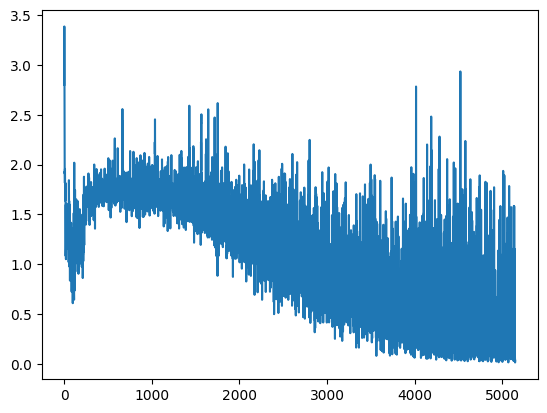

In [ ]:
plt.plot(raw_lossesD)

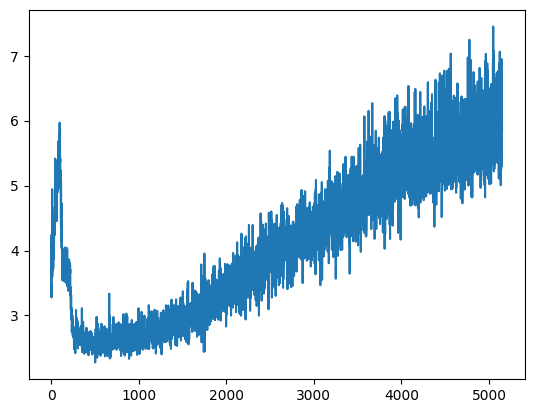

In [ ]:
plt.plot(raw_lossesG)

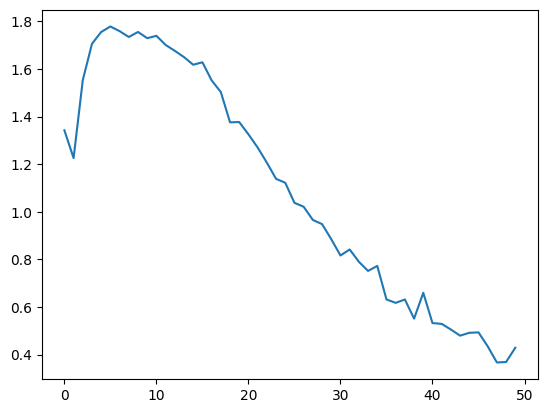

In [ ]:
plt.plot(lossesD)

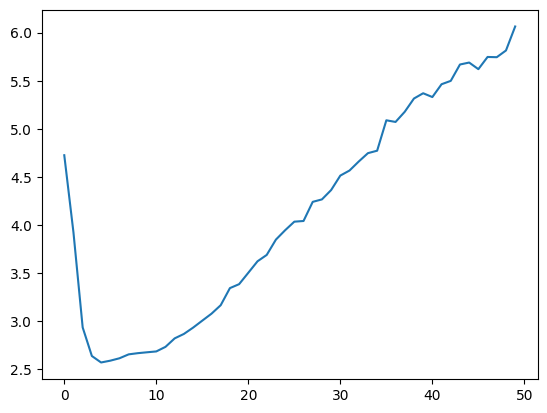

In [ ]:
plt.plot(lossesG)

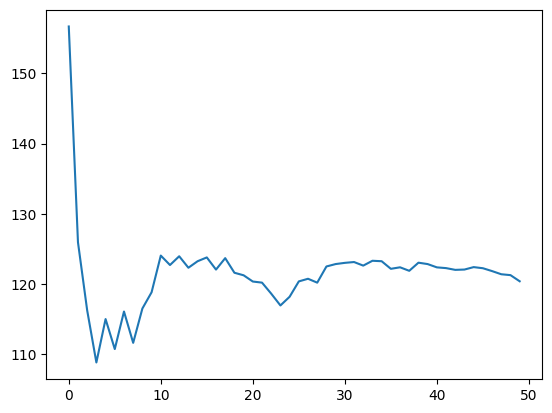

In [ ]:
plt.plot(fid_)

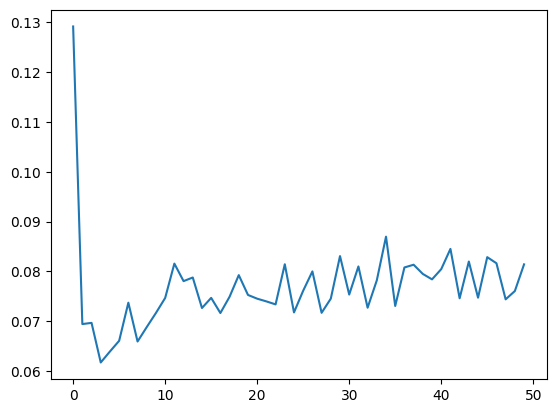

In [ ]:
plt.plot(kid_mean_)

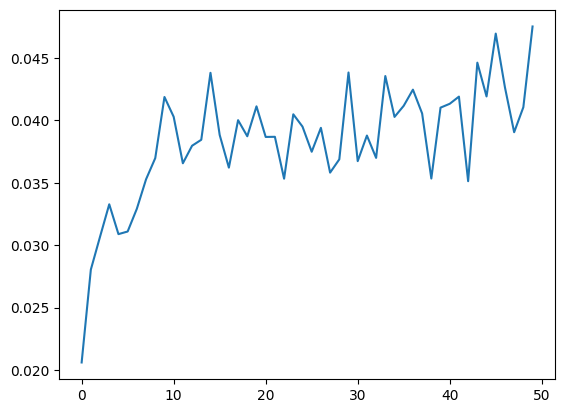

In [ ]:
plt.plot(kid_std_)

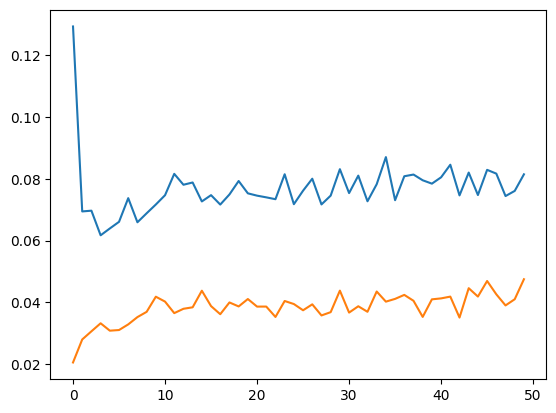

In [ ]:
plt.plot(kid_score)

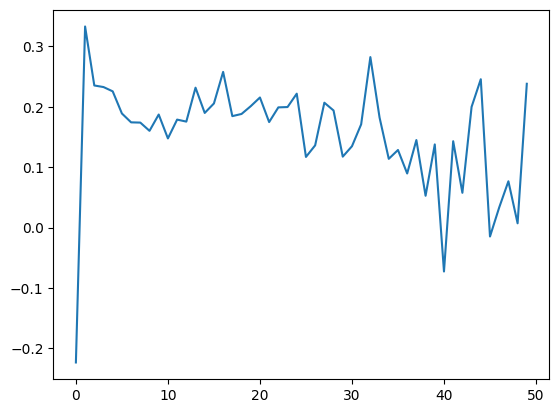

In [ ]:
plt.plot(d_equality)

In [ ]:

real_imgs = real_imgs.to(dtype=torch.uint8).cpu()
fake_imgs = fake_imgs.to(dtype=torch.uint8).cpu()
fid.update(real_imgs, real=True)
fid.update(fake_imgs, real=False)
fid.compute()

kid.update(real_imgs, real=True)
kid.update(fake_imgs, real=False)
kid.compute()

(tensor(0.0742), tensor(0.0417))